In [381]:
# Importing libraries
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib
import seaborn as sns                # Seaborn
import xgboost as xgb                #XGboost 

# Package to implement Decision Tree Model
import sklearn

from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBRegressor

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

# Import MAPIE to calculate prediction intervals
from mapie.regression import MapieRegressor

# To calculate coverage score
from mapie.metrics import regression_coverage_score

# Module to save and load Python objects to and from files
import pickle 

%matplotlib inline

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

In [382]:
# Load dataset as dataframe
traffic_df = pd.read_csv('traffic_volume.csv')

# Replace null with 0 values
traffic_df['holiday']= traffic_df['holiday'].fillna('none')


In [383]:
# #convert to datetime
# traffic_df['date_time'] = pd.to_datetime(traffic_df['date_time'])

# traffic_df.info()
# traffic_df.head()

In [384]:
# # extract month, weekday, hour from date time column
# traffic_df['month'] = traffic_df['date_time'].dt.month_name()
# traffic_df['weekday'] = traffic_df['date_time'].dt.day_name()
# traffic_df['hour'] = traffic_df['date_time'].dt.hour
# traffic_df= traffic_df.drop(columns = ['date_time','weather_description'])
# traffic_df = traffic_df[['holiday','temp','rain_1h','snow_1h','clouds_all','weather_main','month','weekday','hour','traffic_volume']]
# traffic_df.head()

In [ ]:
traffic_df.to_csv('Traffic_Volume.csv', index=False)
#accidentally resaved original df to edited one

In [386]:
#extract feature and target arrays
X = traffic_df.drop(['traffic_volume'], axis=1)
y = traffic_df[['traffic_volume']]

In [387]:
# Split the data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)

In [388]:
estimators = [
    ('encoder', TargetEncoder()),
    ('reg', XGBRegressor(random_state = 0))
]

pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder', TargetEncoder()),
                ('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

In [389]:
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

search_space = {
    'reg__max_depth': Integer(2,8),
    'reg__learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'reg__subsample': Real(0.5, 1.0),
    'reg__colsample_bytree': Real(0.5, 1.0),
    'reg__colsample_bylevel': Real(0.5, 1.0),
    'reg__colsample_bynode' : Real(0.5, 1.0),
    'reg__reg_alpha': Real(0.0, 10.0),
    'reg__reg_lambda': Real(0.0, 10.0),
    'reg__gamma': Real(0.0, 10.0)
}

opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=30, scoring='r2', random_state=0) 

In [390]:
opt.fit(train_X, train_y)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('encoder', TargetEncoder()),
                                        ('reg',
                                         XGBRegressor(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=N...
                             'reg__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'reg__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'reg__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'reg__subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [391]:
opt.best_score_

0.9546711683273316

In [392]:
opt.best_estimator_

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['holiday', 'weather_main', 'month',
                                     'weekday'])),
                ('reg',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=1.0,
                              colsample_bynode=0.7340177059348307,
                              colsample_bytree=1.0, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=10.0, gro...one,
                              importance_type=None,
                              interaction_constraints=None,
                              learning_rate=0.26560163714148083, max_bin=None,
                              max_cat_threshold=None, max_cat_to_onehot=None,
                              max_delta_step=None, max_depth=8, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=0, ...))])

In [393]:
opt.score(test_X, test_y)

0.9538588523864746

In [394]:
test_y

,traffic_volume
44287,5875
2006,2868
6582,557
13779,4354
1721,783
...,...
18938,2855
12883,6331
35157,3136
32593,2624


In [395]:
test_y = pd.DataFrame(test_y)
test_y

,traffic_volume
44287,5875
2006,2868
6582,557
13779,4354
1721,783
...,...
18938,2855
12883,6331
35157,3136
32593,2624


In [396]:
y_pred = opt.predict(test_X)

y_pred = pd.DataFrame(y_pred)

y_pred

,0
0,5559.019043
1,3017.291504
2,547.596130
3,4530.504883
4,1014.545532
...,...
9636,3405.564209
9637,6355.003906
9638,2745.675293
9639,2808.817871


In [397]:
# results_df=pd.concat([test_y,y_pred], ignore_index=True)
results_df = pd.DataFrame()
results_df['Actual'] = test_y
results_df['Predicted'] = y_pred

results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

results_df

,Actual,Predicted,Residual
44287,5875,NaN,NaN
2006,2868,3218.986084,-350.986084
6582,557,5458.912109,-4901.912109
13779,4354,NaN,NaN
1721,783,4364.336426,-3581.336426
...,...,...,...
18938,2855,NaN,NaN
12883,6331,NaN,NaN
35157,3136,NaN,NaN
32593,2624,NaN,NaN


In [398]:
# Predict Test Set
y_pred = opt.predict(test_X)

# Evaluate the model on test set
r2 = sklearn.metrics.r2_score(test_y, y_pred)
print('R-squared on Test Set: %0.2f' %r2)

RMSE_test = sklearn.metrics.root_mean_squared_error(test_y, y_pred)
print('RMSE on Test Set: %0.2f' %RMSE_test)

R-squared on Test Set: 0.95
RMSE on Test Set: 424.79


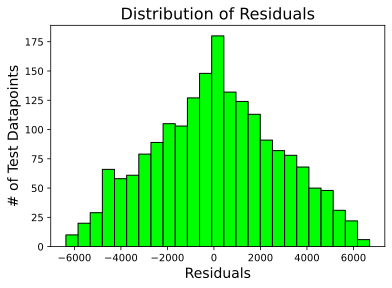

In [399]:
# Calculate the residuals by subtracting the predicted values from the actual test values
all_residuals = results_df['Residual']

# Set up the figure with custom size and resolution (DPI)
plt.figure(figsize=(6, 4), dpi = 150)

# Plot the histogram of residuals
plt.hist(all_residuals, bins = 25, color = 'lime', edgecolor = 'black')

# Label X and Y axes
plt.xlabel('Residuals', fontsize = 14)
plt.ylabel('# of Test Datapoints', fontsize = 14)

# Set the title of the plot
plt.title('Distribution of Residuals', fontsize = 16)

# Adjust the font size of x and y ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('residual_plot.svg')

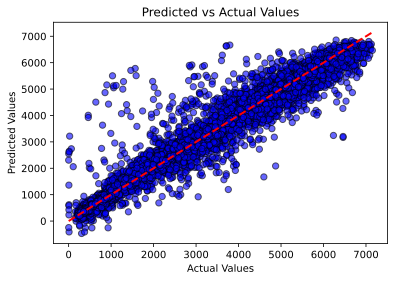

In [400]:
# Setting the figure size and resolution
plt.figure(figsize = (6, 4), dpi = 150)

# Scatter plot of actual vs predicted values
plt.scatter(results_df['Actual'], y_pred, color = 'blue', alpha = 0.6, edgecolor = 'black', s = 40)

# 45-degree reference line (perfect predictions)
plt.plot([min(results_df['Actual']), max(results_df['Actual'])], [min(results_df['Actual']), max(results_df['Actual'])], color = 'red', linestyle = '--', lw = 2)

# Axis labels and title
plt.xlabel('Actual Values', fontsize = 10)
plt.ylabel('Predicted Values', fontsize = 10)
plt.title('Predicted vs Actual Values', fontsize = 12)

# Adjust ticks
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

plt.savefig('pred_vs_actual.svg')

In [401]:
opt.best_estimator_.steps

[('encoder',
  TargetEncoder(cols=['holiday', 'weather_main', 'month', 'weekday'])),
 ('reg',
  XGBRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=1.0, colsample_bynode=0.7340177059348307,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=10.0, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.26560163714148083,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=8, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, random_state=0, ...))]

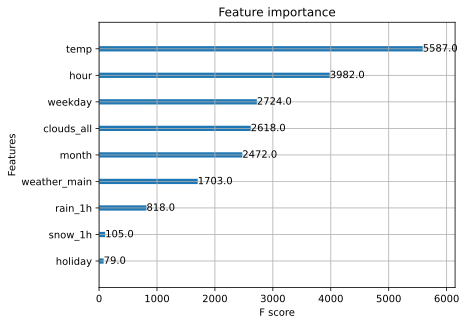

In [402]:
xgboost_step = opt.best_estimator_.steps[1]
xgboost_model = xgboost_step[1]
feat_imp= plot_importance(xgboost_model)


In [403]:
# # Storing importance values from the trained model
# importance = opt.best_estimator_.steps[1]

# # # Storing feature importance as a dataframe
# # feature_imp = pd.DataFrame(list(zip(train_X.columns, importance)),
# #                columns = ['Feature', 'Importance'])

# # feature_imp = feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# # Bar plot
# plt.figure(figsize=(8, 4))
# plt.barh(feat_plot, color = ['red', 'lime'])

# plt.xlabel("Importance", fontsize = 12)
# plt.ylabel("Input Feature", fontsize = 12)
# plt.title('Which features are the most important for predicting admission chances?', fontsize = 12) 
# plt.yticks(fontsize = 10) # fontsize of yticks
# plt.xticks(fontsize = 10) # fontsize of xticks

# plt.tight_layout();

# plt.savefig('feature_imp.svg')

In [404]:
# Define MAPIE regressor
mapie = MapieRegressor(estimator = opt, # Prediction model to use
                       n_jobs = -1, #-1 means using all available CPUs; suggested 4-5 cores
                       random_state = 42)

# Fit mapie regressor on training data 
mapie.fit(train_X, train_y)            

alpha = 0.1 # For 90% confidence level

# Use mapie.predict() to get predicted values and intervals
y_test_pred, y_test_pis = mapie.predict(test_X, alpha = alpha)
#pis = prediction intervals of each data point

c:\Users\jezyw\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [405]:
# Predicted values
y_test_pred

array([5559.019  , 3017.2915 ,  547.5961 , ..., 2745.6753 , 2808.8179 ,
        650.94165], dtype=float32)

In [406]:
# Prediction Intervals
y_test_pis

array([[[5276.02099609],
        [6391.37060547]],

       [[2249.03271484],
        [3391.65161133]],

       [[  25.02264404],
        [1139.7074585 ]],

       ...,

       [[2449.453125  ],
        [3573.99194336]],

       [[2203.03198242],
        [3323.22143555]],

       [[  14.8729248 ],
        [1139.06921387]]])

In [407]:
# Storing results in a dataframe
# test_y_vals = pd.DataFrame()

predictions = results_df['Actual'].to_frame()
predictions.columns = ['Actual Value']
predictions["Predicted Value"] = y_test_pred.round(2)
predictions["Lower Value"] = y_test_pis[:, 0].round(2)
predictions["Upper Value"] = y_test_pis[:, 1].round(2)

# Take a quick look
predictions.tail(5)

,Actual Value,Predicted Value,Lower Value,Upper Value
18938,2855,3405.560059,2828.73,4179.53
12883,6331,6355.000000,5748.99,6903.84
35157,3136,2745.679932,2449.45,3573.99
32593,2624,2808.820068,2203.03,3323.22
11025,624,650.940002,14.87,1139.07


In [408]:
coverage = regression_coverage_score(test_y,           # Actual values
                                     y_test_pis[:, 0], # Lower bound of prediction intervals
                                     y_test_pis[:, 1]) # Upper bound of prediction intervals

coverage_percentage = coverage * 100
print(f"Coverage: {coverage_percentage:.2f}%")

Coverage: 91.74%


c:\Users\jezyw\anaconda3\Lib\site-packages\mapie\utils.py:620: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


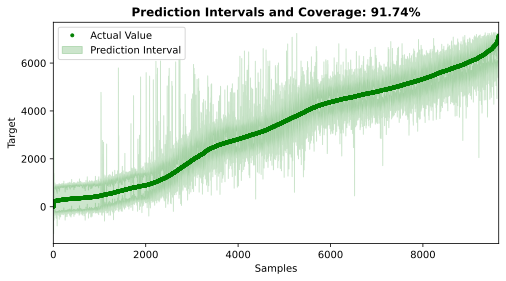

In [409]:
# Sort the predictions by 'Actual Value' for better visualization and reset the index
sorted_predictions = predictions.sort_values(by=['Actual Value']).reset_index(drop=True)

# Create a figure and axis object with specified size and resolution
fig, ax = plt.subplots(figsize=(8, 4))

# Plot the actual values with green dots
plt.plot(sorted_predictions["Actual Value"], 'go', markersize=3, label="Actual Value")

# Fill the area between the lower and upper bounds of the prediction intervals with semi-transparent green color
plt.fill_between(np.arange(len(sorted_predictions)),
                 sorted_predictions["Lower Value"],
                 sorted_predictions["Upper Value"],
                 alpha=0.2, color="green", label="Prediction Interval")

# Set font size for x and y ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Set the limit for the x-axis to cover the range of samples
plt.xlim([0, len(sorted_predictions)])

# Label the x-axis and y-axis with appropriate font size
plt.xlabel("Samples", fontsize=10)
plt.ylabel("Target", fontsize=10)

# Add a title to the plot, including the coverage percentage, with bold formatting
plt.title(f"Prediction Intervals and Coverage: {coverage_percentage:.2f}%", fontsize=12, fontweight="bold")

# Add a legend to the plot, placed in the upper left, with specified font size
plt.legend(loc="upper left", fontsize=10);

plt.savefig('coverage.svg')

In [410]:
# Pickle file: saving the trained XGB model
# Creating the file where we want to write the model
reg_pickle = open('reg_traffic.pickle', 'wb') 

# Write DT model to the file
pickle.dump(mapie, reg_pickle) 

# Close the file
reg_pickle.close() 